# <u> Landmark Detection - Kaggle competition </u>

<b>Name : </b> <i> Rofin Andonissamy</i> <br>
<b> Description :</b>Train a Convolutional Neural Network using "Transfer Learning"" approach, to do landmark detection. Details of the implementation are as follows: <BR>
  
  <b>  Deep Learning Framework used: </b> PyTorch <br>
  <b>  Network Architecture used: </b> Resnet50 <br>
  <b>  Pretrained weights used: </b> Weights obtained by training imagenet dataset <br>

<i><u>Note:</u> Weights at all the layers of this model has been fine tuned to achive better accuracy. The overall accuracy achieved by tuning only the last fully connected layer is comparatively lesser than that of the accuracy achieve by this model. 


In [1]:
#----Import Libraries

#----General libraries for datastructures
import pandas as pd
import numpy as np

#----Pytorch framework for modelling neural network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset

#----Pytorch framework for loading dataset and image processing
from torch.utils.data import DataLoader
import torch.utils.data as data
from PIL import Image

#--- Utility libraries
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import time
import os
import copy

#### Image Preprocessing

<br> Define transformation rules for images in the training and test datasets. 

In [2]:
#-----Define transformation

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#### Define the logic for creating a custom dataset
Overidden the Dataset class to load the image data and labels provided in the respective CSV files

In [3]:
class read_dataset(Dataset):
    def __init__(self, csv_path, img_path, img_ext, transform=None):
        #----Read the input csv file
        inp_df = pd.read_csv(csv_path,header=None)
        inp_df.columns=["image","url","label"]
        inp_df['label'] = inp_df['label']
        #----Make sure if all the images mentioned in the csv file is availabe in the image directory
        assert(inp_df['image'].apply(lambda x: os.path.isfile(img_path + x + img_ext)).all())
        #----Populate the instance variables with the image and name
        self.mlb = MultiLabelBinarizer()
        self.img_path = img_path
        self.img_ext = img_ext
        self.transform = transform
        self.X_train = inp_df['image']
        self.y_train = np.array(inp_df['label'])
        self.img = []
        #---- Read the image from directory
        for idx in range(len(self.X_train)):
            img = Image.open(self.img_path + self.X_train[idx] + self.img_ext)
            self.img.append(img.convert('RGB'))
        
    def __getitem__(self, index):
        #----Apply the required transformation
        if self.transform is not None:
            img = self.transform(self.img[index])
        label = torch.from_numpy(np.array(self.y_train[index])).long()
        return img, label
    
    def __len__(self):
        return len(self.X_train.index)

#### Instantiate the dataloader with the training dataset
Instantiate the dataset to read the training details from the respective csv file and pass its referrence to the dataloader, so that we can load a batch of 32 images at every iteration of the training

In [4]:
#------- Create the training dataset
train_dataset = read_dataset('HW3_train.csv','images/','.jpg',data_transforms['train'])

#----Load Training data
train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=False,
                          num_workers=1 # 1 for CUDA
                         # pin_memory=True # CUDA only
                         )

#### Download a Pretrained Resnet50 model and replace the final fully connected layer to perform transfer learning

<i>Note:</i> For the training purpose, Stochostic Gradient function with momentum has been is used with a learning deccay rate of 0.1 (for 7 steps). Crossentropy loss function has been used to evaluate the loss 

In [5]:
#----Check if GPU is available for use, else use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#--- Import a pretrained Resnet18 network  and download the pretrained weights
model_ft = models.resnet50(pretrained=True)


#--- get the input dimension for the fully connected layer
num_ftrs = model_ft.fc.in_features
#--- Change the fully connected layer with 10 output layers
model_ft.fc = nn.Linear(num_ftrs, 10)
#--- Assigned the model to the available device  
model_ft = model_ft.to(device)

#---Loss function
criterion = nn.CrossEntropyLoss()

# Initialize the optimizer function- ADAM optimization
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#### Define the training logic

In [7]:
def train_model(model, criterion, optimizer,scheduler, num_epochs):
    since = time.time()
    
    for epoch in range(num_epochs):
        dataset_sizes = 0
        #----Display the epoch details
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        #----Start the training 
        model.train()
        #-----Reset metric variabe
        running_loss = 0.0
        running_corrects = 0
        #----- Iterate throught the image loader
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward propogation
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            #----Compute the loss
            loss = criterion(outputs, labels)
            
            #----Perform backward propogation 
            loss.backward()
            optimizer.step()
            
            #---- Statistics
            running_loss += loss.item() * images.size(0)
            dataset_sizes+=images.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / dataset_sizes
        epoch_acc = running_corrects.double() / dataset_sizes
        #------Display Epoch result
        print('Loss: {:.4f}'.format(epoch_loss),'Acc: {:.4f}'.format(epoch_acc))
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model    
            

#### Run the training

Note: Training the model for 6 Epochs gave good accuracy

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft,exp_lr_scheduler,
                       num_epochs=6)

Epoch 1/6
----------
Loss: 0.4527 Acc: 0.8606
Epoch 2/6
----------
Loss: 0.1821 Acc: 0.9421
Epoch 3/6
----------
Loss: 0.1427 Acc: 0.9551
Epoch 4/6
----------
Loss: 0.1236 Acc: 0.9597
Epoch 5/6
----------
Loss: 0.1107 Acc: 0.9636
Epoch 6/6
----------
Loss: 0.0938 Acc: 0.9702
Training complete in 65m 43s


#### Create Dataset and instantiate DataLoader for Test dataset to evaluate model's performance

In [9]:
#------- Create the test dataset
test_dataset = read_dataset('HW3_test.csv','images/','.jpg',data_transforms['test'])

#----Load Training data
test_loader   = DataLoader(test_dataset,
                          batch_size=32,
                          shuffle=False,
                          num_workers=1 # 1 for CUDA
                         # pin_memory=True # CUDA only
                         )

#### Define the logic for evaluating the test performance

In [10]:
  def test_model(model, criterion):
    dataset_sizes = 0  
    confusion_matrix = torch.zeros(10, 10)
    #-----Evauluate the model
    model.eval()
    #-----Reset metric variabe
    running_loss = 0.0
    running_corrects = 0
    #----- Iterate throught the image loader
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        #-----Make prediction
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        #----Compute the loss
        loss = criterion(outputs, labels)

        #---- Calculate the metrics
        running_loss += loss.item() * images.size(0)
        dataset_sizes+=images.size(0)
        running_corrects += torch.sum(preds == labels.data)
        #---- Build confusion matrix
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()]+= 1
        
    tot_loss = running_loss / dataset_sizes
    tot_acc = running_corrects.double() / dataset_sizes
    #------Display the evaluation metric
    print('Loss: {:.4f}'.format(tot_loss),'Acc: {:.4f}'.format(tot_acc))
    #--- return confusion matrix
    return confusion_matrix

#### Evaluate the model's performance by predicting labels for novice test images 

<b><u><i>Accuracy of the prediction on test data is 99.1% </b></u></i>

In [15]:
conf_mat = test_model(model_ft,criterion)

Loss: 0.0295 Acc: 0.9916


#### Raw Confusion Matrix

In [16]:
conf_mat = conf_mat.cpu().numpy()
print(conf_mat)

[[340.   0.   0.   1.   0.   0.   0.   0.   0.   0.]
 [  0. 391.   0.   0.   0.   0.   0.   0.   1.   0.]
 [  0.   1. 355.   3.   0.   0.   1.   0.   1.   0.]
 [  0.   0.   1. 336.   0.   0.   2.   0.   0.   0.]
 [  1.   0.   0.   0. 340.   1.   0.   1.   1.   1.]
 [  0.   0.   0.   0.   1. 336.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 309.   0.   0.   0.]
 [  0.   0.   0.   0.   1.   0.   0. 314.   1.   0.]
 [  1.   0.   1.   0.   2.   1.   1.   1. 325.   0.]
 [  0.   1.   0.   0.   0.   0.   1.   0.   0. 243.]]


#### Visualize the raw confusion matrix

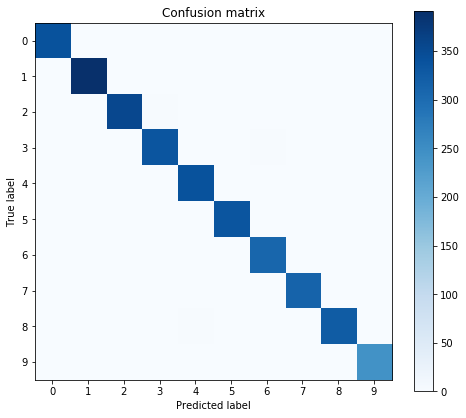

In [17]:
#----Plot the raw confusion matrix
fig, ax = plt.subplots()
fig.set_size_inches(8,7)
img = ax.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(img, ax=ax)
ax.set(xticks=np.arange(conf_mat.shape[1]),
yticks=np.arange(conf_mat.shape[0]),
# ... and label them with the respective list entries
xticklabels=[0,1,2,3,4,5,6,7,8,9], yticklabels=[0,1,2,3,4,5,6,7,8,9],
           title="Confusion matrix",
           ylabel='True label',
           xlabel='Predicted label')
plt.show()

#### Normalized  Confusion Matrix

In [77]:
#----Normalized confusion matix
Norm_conf_mat = conf_mat.astype('float32') / conf_mat.sum(axis=1)[:, np.newaxis]
print(Norm_conf_mat.round(3))

[[0.997 0.    0.    0.003 0.    0.    0.    0.    0.    0.   ]
 [0.    0.997 0.    0.    0.    0.    0.    0.    0.003 0.   ]
 [0.    0.003 0.983 0.008 0.    0.    0.003 0.    0.003 0.   ]
 [0.    0.    0.003 0.991 0.    0.    0.006 0.    0.    0.   ]
 [0.003 0.    0.    0.    0.986 0.003 0.    0.003 0.003 0.003]
 [0.    0.    0.    0.    0.003 0.997 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.003 0.    0.    0.994 0.003 0.   ]
 [0.003 0.    0.003 0.    0.006 0.003 0.003 0.003 0.979 0.   ]
 [0.    0.004 0.    0.    0.    0.    0.004 0.    0.    0.992]]


#### Visualize the normalized confusion Matrix

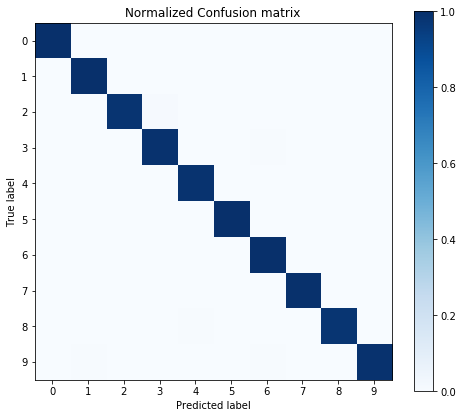

In [19]:
#----Plot the confusion matrix
fig, ax = plt.subplots()
fig.set_size_inches(8,7)
img = ax.imshow(Norm_conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(img, ax=ax)
ax.set(xticks=np.arange(Norm_conf_mat.shape[1]),
yticks=np.arange(Norm_conf_mat.shape[0]),
# ... and label them with the respective list entries
xticklabels=[0,1,2,3,4,5,6,7,8,9], yticklabels=[0,1,2,3,4,5,6,7,8,9],
           title="Normalized Confusion matrix",
           ylabel='True label',
           xlabel='Predicted label')
plt.show()

#### Accuracy of prediction for each of the classes

In [64]:
accuracy_of_lab_pred = Norm_conf_mat.diagonal()

#----Populate a dataframe for reporting 
acc_df = pd.DataFrame()
acc_df['accuracy'] = accuracy_of_lab_pred
acc_df['labels'] = np.arange(len(acc_df))
acc_df = acc_df[['labels','accuracy']]
acc_df

,labels,accuracy
0,0,0.997067
1,1,0.997449
2,2,0.983379
3,3,0.991150
4,4,0.985507
5,5,0.997033
6,6,1.000000
7,7,0.993671
8,8,0.978916
9,9,0.991837


#### Most Accurately predicted label

In [69]:
print("Most accurately predicted label: ")
acc_df.sort_values(by='accuracy',ascending = False).head(1)

Most accurately predicted label: 


,labels,accuracy
6,6,1.0


#### Least Accurately predicted label

In [72]:
print("Least accurately predicted label: ")
acc_df.sort_values(by='accuracy',ascending = True).head(3)

Least accurately predicted label: 


,labels,accuracy
8,8,0.978916
2,2,0.983379
4,4,0.985507


#### True Positives for each classes predicted

In [43]:
#----True Positive
TP = conf_mat.diagonal()

#---- Populate a dataframe for reporting 
tp_df = pd.DataFrame()
tp_df['True Positive count'] = TP
tp_df['labels'] = np.arange(len(tp_df))
tp_df = tp_df[['labels','True Positive count']]
tp_df

,labels,True Positive count
0,0,340.0
1,1,391.0
2,2,355.0
3,3,336.0
4,4,340.0
5,5,336.0
6,6,309.0
7,7,314.0
8,8,325.0
9,9,243.0


#### False Positives for each classes predicted

In [42]:
#-----False positive
FP = np.sum(conf_mat,axis=0) - TP
fp_df = pd.DataFrame()
fp_df['False Positive count'] = FP
fp_df['labels'] = np.arange(len(fp_df))
fp_df = fp_df[['labels','False Positive count']]
fp_df

,labels,False Positive count
0,0,2.0
1,1,2.0
2,2,2.0
3,3,4.0
4,4,4.0
5,5,2.0
6,6,5.0
7,7,2.0
8,8,4.0
9,9,1.0


#### False Negatives for each classes predicted

In [46]:
#-----False Negative
FN = np.sum(conf_mat,axis=1) - TP

fn_df = pd.DataFrame()
fn_df['False Negative count'] = FN
fn_df['labels'] = np.arange(len(fn_df))
fn_df=fn_df[['labels','False Negative count']]
fn_df

,labels,False Negative count
0,0,1.0
1,1,1.0
2,2,6.0
3,3,3.0
4,4,5.0
5,5,1.0
6,6,0.0
7,7,2.0
8,8,7.0
9,9,2.0


#### Precision and Recall for each class predicted

In [54]:
#----Calculate precision
precision = TP/(TP+FP)
#----Calculate recall
recall = TP/(TP+FN)

In [55]:
prc_rec_df = pd.DataFrame()
prc_rec_df['Precision'] = precision
prc_rec_df['Recall'] = recall
prc_rec_df['labels'] = np.arange(len(prc_rec_df))
prc_rec_df = prc_rec_df[['labels','Precision','Recall']]
prc_rec_df

,labels,Precision,Recall
0,0,0.994152,0.997067
1,1,0.994911,0.997449
2,2,0.994398,0.983379
3,3,0.988235,0.991150
4,4,0.988372,0.985507
5,5,0.994083,0.997033
6,6,0.984076,1.000000
7,7,0.993671,0.993671
8,8,0.987842,0.978916
9,9,0.995902,0.991837


#### Bar plots of precision and recall for each class

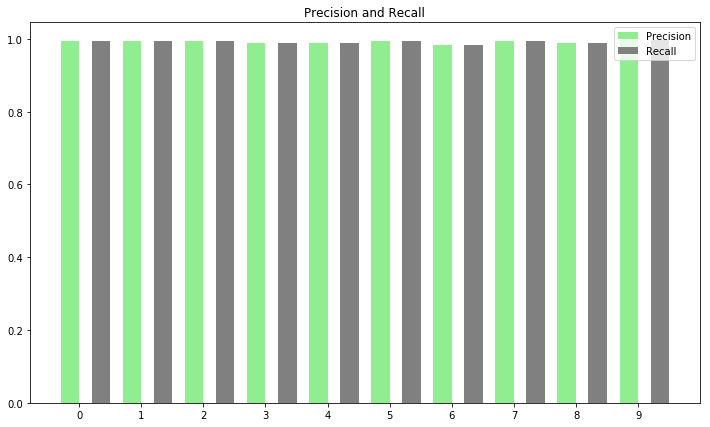

In [63]:
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
bar1 = ax.bar(np.arange(10),precision,0.3,color='lightgreen')
bar2 = ax.bar(np.arange(10)+0.5,precision,0.3,color='gray')
ax.set_title('Precision and Recall')
ax.set_xticks(np.arange(10) + 0.3 / 2)
ax.set_xticklabels(('0', '1', '2', '3', '4','5','6','7','8','9'))
ax.legend((bar1[0], bar2[0]), ('Precision', 'Recall'))
ax.autoscale_view()

plt.show()


### <u>Summary</u> 
<b>1. Accuracy of the model on test data is 99.1% <br>2. Raw Confusion Matrix: </b>

In [73]:
print(conf_mat)

[[340.   0.   0.   1.   0.   0.   0.   0.   0.   0.]
 [  0. 391.   0.   0.   0.   0.   0.   0.   1.   0.]
 [  0.   1. 355.   3.   0.   0.   1.   0.   1.   0.]
 [  0.   0.   1. 336.   0.   0.   2.   0.   0.   0.]
 [  1.   0.   0.   0. 340.   1.   0.   1.   1.   1.]
 [  0.   0.   0.   0.   1. 336.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 309.   0.   0.   0.]
 [  0.   0.   0.   0.   1.   0.   0. 314.   1.   0.]
 [  1.   0.   1.   0.   2.   1.   1.   1. 325.   0.]
 [  0.   1.   0.   0.   0.   0.   1.   0.   0. 243.]]


<b>3. Normalized Confusion Matrix:</b>

In [76]:
print(Norm_conf_mat.round(3))

[[0.997 0.    0.    0.003 0.    0.    0.    0.    0.    0.   ]
 [0.    0.997 0.    0.    0.    0.    0.    0.    0.003 0.   ]
 [0.    0.003 0.983 0.008 0.    0.    0.003 0.    0.003 0.   ]
 [0.    0.    0.003 0.991 0.    0.    0.006 0.    0.    0.   ]
 [0.003 0.    0.    0.    0.986 0.003 0.    0.003 0.003 0.003]
 [0.    0.    0.    0.    0.003 0.997 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.003 0.    0.    0.994 0.003 0.   ]
 [0.003 0.    0.003 0.    0.006 0.003 0.003 0.003 0.979 0.   ]
 [0.    0.004 0.    0.    0.    0.    0.004 0.    0.    0.992]]


<<b>4. Most accurately predicted category:</b>

Note : Accuracy has been determined from the normalized confusion matrix and the most accurate and least accurate prediction are determined using the accuracy

In [83]:
acc_df.sort_values(by='accuracy',ascending = False).head(1)

,labels,accuracy
6,6,1.0


<b>5. Least accurately predicted category:8
   <br> The other least accurately predicted and most often confused category was 2 </b>

In [80]:
acc_df.sort_values(by='accuracy',ascending = True).head(2)

,labels,accuracy
8,8,0.978916
2,2,0.983379


<b>6. Precision and Recall:</b>

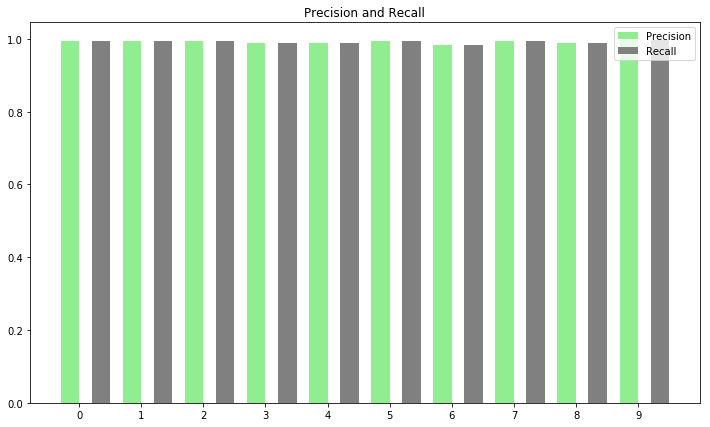

,labels,Precision,Recall
0,0,0.994152,0.997067
1,1,0.994911,0.997449
2,2,0.994398,0.983379
3,3,0.988235,0.991150
4,4,0.988372,0.985507
5,5,0.994083,0.997033
6,6,0.984076,1.000000
7,7,0.993671,0.993671
8,8,0.987842,0.978916
9,9,0.995902,0.991837


In [82]:

fig, ax = plt.subplots()
fig.set_size_inches(12,7)
bar1 = ax.bar(np.arange(10),precision,0.3,color='lightgreen')
bar2 = ax.bar(np.arange(10)+0.5,precision,0.3,color='gray')
ax.set_title('Precision and Recall')
ax.set_xticks(np.arange(10) + 0.3 / 2)
ax.set_xticklabels(('0', '1', '2', '3', '4','5','6','7','8','9'))
ax.legend((bar1[0], bar2[0]), ('Precision', 'Recall'))
ax.autoscale_view()
plt.show()

prc_rec_df